# Evaluation
## Scenario
Our evaluation criteria include conducting load tests to assess the performance impact of containers and serverless implementations. To achieve this, we use Apache JMeter as a testing tool to measure the response time of the system. We simulated 100 users sending generate image requests to our system and observed their respective response times at one-minute intervals over a 10-minute duration.


## Explanation

1. **Server Processing Time**: This refers to the amount of time the server takes to process a request. It starts when the server receives the request and ends when it has processed the request and is ready to send the response. This includes the time taken for processing logic, database queries, and other server-side activities.

2. **Elapsed Time**: Elapsed time is the total time from when a client sends a request until it receives a complete response from the server. This includes the server processing time, the time for the request and response to travel across the network, and any other delays that might occur.

3. **Latency**: Latency typically refers to the time it takes from sending out a request to the beginning of receiving a response. This is mainly the network delay, including the time for the request to reach the server and the time before the server starts responding.

**Performance Evaluation**:
- Low latency and low server processing time generally indicate that the server is responding quickly to requests.
- A longer total elapsed time could be due to network delays, high server load, or slow client processing.
- If server processing time constitutes a major part of the elapsed time, optimizing server processing efficiency might be key to improving performance.
- If latency takes up a significant portion of the elapsed time, investigating network conditions or optimizing server response time may be necessary.

In [49]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import json

In [50]:
def read_xml(path):
    df = pd.read_xml(path, xpath='//httpSample')
    try:
        df['processing_time'] = df['responseData'].apply(
    lambda x: round(json.loads(x).get('time'), 2) if pd.notna(x) and json.loads(x).get('time') is not None else None
)
    except json.JSONDecodeError:
        print("Error in JSON decoding")
        df['processing_time'] = None
    return df

In [51]:
docker_data = pd.read_csv("./Docker.csv")
docker_response = read_xml("./Docker.xml").rename(columns={"ts": "timeStamp"})
serverless_data = pd.read_csv("./Serverless.csv")
serverless_response = read_xml("./Serverless.xml").rename(columns={"ts": "timeStamp"})

# Covert the timestamp
time_format = "%H:%M:%S.%f"
time_format_nm = "%H:%M"
docker_data["timeStamp"] = pd.to_datetime(docker_data["timeStamp"],unit='ms').dt.strftime(time_format_nm)
docker_response["timeStamp"] = pd.to_datetime(docker_response["timeStamp"],unit='ms').dt.strftime(time_format_nm)
serverless_data["timeStamp"] = pd.to_datetime(serverless_data["timeStamp"],unit='ms').dt.strftime(time_format_nm)
serverless_response["timeStamp"] = pd.to_datetime(serverless_response["timeStamp"],unit='ms').dt.strftime(time_format_nm)

docker_data = pd.merge(docker_data, docker_response, on='timeStamp', how='outer')
serverless_data = pd.merge(serverless_data, serverless_response, on='timeStamp', how='outer')

### Response time
#### Calculate the mean value

In [52]:
mean_response_docker = docker_data["response_time"].mean()
std_response_docker = docker_data["response_time"].std()
mean_response_serverless = serverless_data["response_time"].mean()
std_response_serverless = serverless_data["response_time"].std()

print(f'Containers:\nMean response time: {mean_response_docker:.2f} ms, Std response time: {std_response_docker:.2f} ms')
print(f'Serverless:\nMean response time: {mean_response_serverless:.2f} ms, Std response time: {std_response_serverless:.2f} ms')

Containers:
Mean response time: 61992.14 ms, Std response time: 9110.89 ms
Serverless:
Mean response time: 6985.17 ms, Std response time: 2661.97 ms


#### Plot

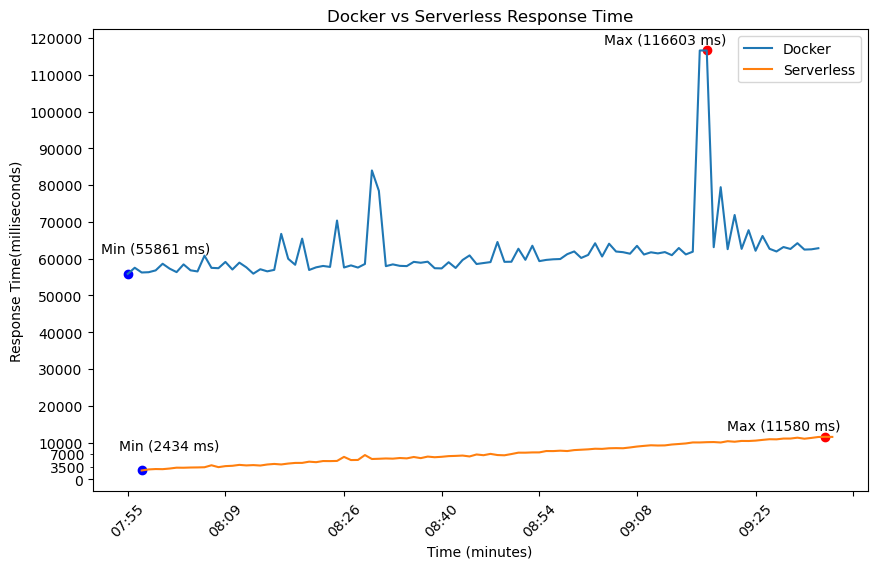

In [53]:

docker_data['type'] = 'Docker'
serverless_data['type'] = 'Serverless'

combined_data = pd.concat([docker_data, serverless_data])


plt.figure(figsize=(10, 6))

for _type, data in combined_data.groupby('type'):
    plt.plot(data['timeStamp'], data['response_time'], label=_type)

    max_value = data['response_time'].max()
    max_time = data[data['response_time'] == max_value]['timeStamp'].iloc[0]
    plt.scatter(max_time, max_value, color='red') 
    plt.annotate(f'Max ({max_value} ms)', (max_time, max_value), textcoords="offset points", xytext=(-30,5), ha='center')

    min_value = data['response_time'].min()
    min_time = data[data['response_time'] == min_value]['timeStamp'].iloc[0]
    plt.scatter(min_time, min_value, color='blue')
    plt.annotate(f'Min ({min_value} ms)', (min_time, min_value), textcoords="offset points", xytext=(20,15), ha='center')



plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
main_locator = plt.MaxNLocator(13)
plt.gca().yaxis.set_major_locator(main_locator)  
lower_max = 10000
minor_ticks = np.arange(0, lower_max + 1, 3500)

main_ticks = main_locator.tick_values(plt.gca().get_ylim()[0], plt.gca().get_ylim()[1])
minor_ticks = [tick for tick in minor_ticks if tick not in main_ticks]

plt.gca().yaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
plt.gca().yaxis.set_minor_formatter(plt.FixedFormatter([str(v) for v in minor_ticks]))

plt.legend(loc="upper right")
plt.xticks(rotation=45)
plt.xlabel("Time (minutes)")
plt.ylabel("Response Time(milliseconds)")
plt.title("Docker vs Serverless Response Time")
plt.show()

### Latency
#### Calculate the mean value

In [54]:
mean_response_docker = docker_data["Latency"].mean()
std_response_docker = docker_data["Latency"].std()
mean_response_serverless = serverless_data["Latency"].mean()
std_response_serverless = serverless_data["Latency"].std()

print(f'Containers:\nMean Latency time: {mean_response_docker:.2f} ms, Std Latency time: {std_response_docker:.2f} ms')
print(f'Serverless:\nMean Latency time: {mean_response_serverless:.2f} ms, Std Latency time: {std_response_serverless:.2f} ms')

Containers:
Mean Latency time: 61850.93 ms, Std Latency time: 9112.20 ms
Serverless:
Mean Latency time: 6847.56 ms, Std Latency time: 2657.84 ms


#### Plot

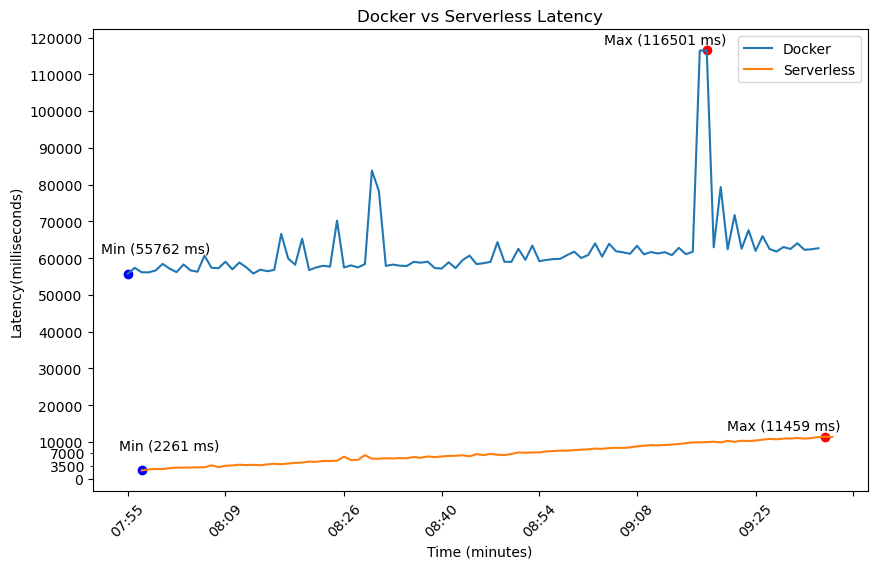

In [55]:
plt.figure(figsize=(10, 6))

for _type, data in combined_data.groupby('type'):
    plt.plot(data['timeStamp'], data['Latency'], label=_type)

    max_value = data['Latency'].max()
    max_time = data[data['Latency'] == max_value]['timeStamp'].iloc[0]
    plt.scatter(max_time, max_value, color='red') 
    plt.annotate(f'Max ({max_value} ms)', (max_time, max_value), textcoords="offset points", xytext=(-30,5), ha='center')

    min_value = data['Latency'].min()
    min_time = data[data['Latency'] == min_value]['timeStamp'].iloc[0]
    plt.scatter(min_time, min_value, color='blue')
    plt.annotate(f'Min ({min_value} ms)', (min_time, min_value), textcoords="offset points", xytext=(20,15), ha='center')



plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
main_locator = plt.MaxNLocator(13)
plt.gca().yaxis.set_major_locator(main_locator)  
lower_max = 10000
minor_ticks = np.arange(0, lower_max + 1, 3500)

main_ticks = main_locator.tick_values(plt.gca().get_ylim()[0], plt.gca().get_ylim()[1])
minor_ticks = [tick for tick in minor_ticks if tick not in main_ticks]

plt.gca().yaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
plt.gca().yaxis.set_minor_formatter(plt.FixedFormatter([str(v) for v in minor_ticks]))

plt.legend(loc="upper right")
plt.xticks(rotation=45)
plt.xlabel("Time (minutes)")
plt.ylabel("Latency(milliseconds)")
plt.title("Docker vs Serverless Latency")
plt.show()

### Server Processing Time
#### Calculate the mean value

In [56]:
mean_response_docker = docker_data["processing_time"].mean()
std_response_docker = docker_data["processing_time"].std()
mean_response_serverless = serverless_data["processing_time"].mean()
std_response_serverless = serverless_data["processing_time"].std()

print(f'Containers:\nMean Server Processing time: {mean_response_docker:.2f} ms, Std Server Processing time: {std_response_docker:.2f} ms')
print(f'Serverless:\nMean Server Processing time: {mean_response_serverless:.2f} ms, Std Server Processing time: {std_response_serverless:.2f} ms')

Containers:
Mean Server Processing time: 61706.95 ms, Std Server Processing time: 9113.64 ms
Serverless:
Mean Server Processing time: 6700.31 ms, Std Server Processing time: 2659.56 ms


#### Plot

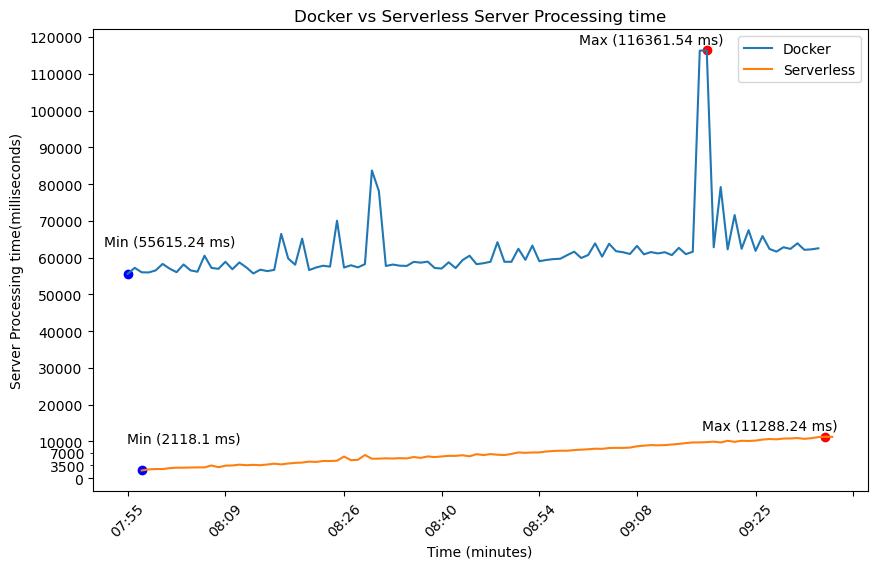

In [57]:
plt.figure(figsize=(10, 6))

for _type, data in combined_data.groupby('type'):
    plt.plot(data['timeStamp'], data['processing_time'], label=_type)

    max_value = data['processing_time'].max()
    max_time = data[data['processing_time'] == max_value]['timeStamp'].iloc[0]
    plt.scatter(max_time, max_value, color='red') 
    plt.annotate(f'Max ({max_value} ms)', (max_time, max_value), textcoords="offset points", xytext=(-40,5), ha='center')

    min_value = data['processing_time'].min()
    min_time = data[data['processing_time'] == min_value]['timeStamp'].iloc[0]
    plt.scatter(min_time, min_value, color='blue')
    plt.annotate(f'Min ({min_value} ms)', (min_time, min_value), textcoords="offset points", xytext=(30,20), ha='center')



plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
main_locator = plt.MaxNLocator(13)
plt.gca().yaxis.set_major_locator(main_locator)  
lower_max = 10000
minor_ticks = np.arange(0, lower_max + 1, 3500)

main_ticks = main_locator.tick_values(plt.gca().get_ylim()[0], plt.gca().get_ylim()[1])
minor_ticks = [tick for tick in minor_ticks if tick not in main_ticks]

plt.gca().yaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
plt.gca().yaxis.set_minor_formatter(plt.FixedFormatter([str(v) for v in minor_ticks]))

plt.legend(loc="upper right")
plt.xticks(rotation=45)
plt.xlabel("Time (minutes)")
plt.ylabel("Server Processing time(milliseconds)")
plt.title("Docker vs Serverless Server Processing time")
plt.show()

### Connect
#### Calculate the mean value

In [58]:
mean_response_docker = docker_data["Connect"].mean()
std_response_docker = docker_data["Connect"].std()
mean_response_serverless = serverless_data["Connect"].mean()
std_response_serverless = serverless_data["Connect"].std()

print(f'Containers:\nMean Connect: {mean_response_docker:.2f} ms, Std Connect: {std_response_docker:.2f} ms')
print(f'Serverless:\nMean Connect: {mean_response_serverless:.2f} ms, Std Connect: {std_response_serverless:.2f} ms')

Containers:
Mean Connect: 58.94 ms, Std Connect: 18.61 ms
Serverless:
Mean Connect: 62.28 ms, Std Connect: 14.52 ms


#### Plot

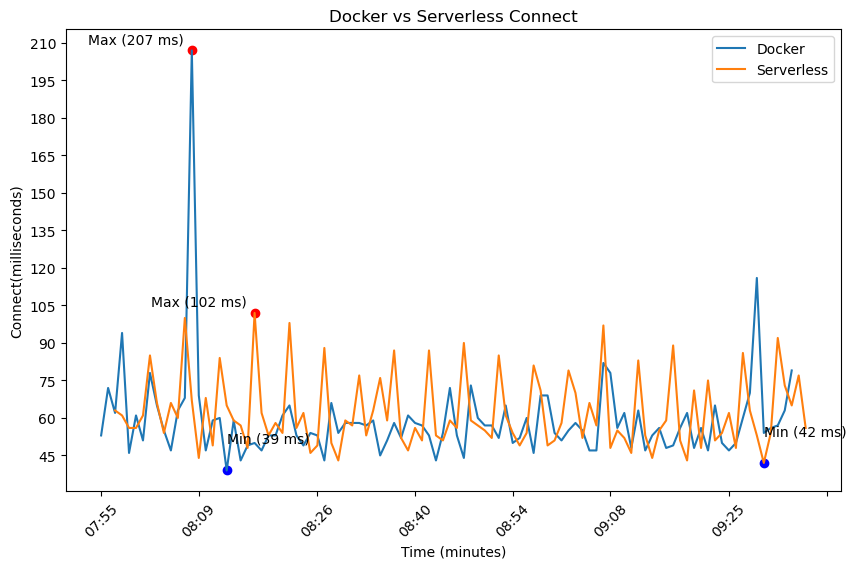

In [59]:
plt.figure(figsize=(10, 6))

for _type, data in combined_data.groupby('type'):
    plt.plot(data['timeStamp'], data['Connect'], label=_type)

    max_value = data['Connect'].max()
    max_time = data[data['Connect'] == max_value]['timeStamp'].iloc[0]
    plt.scatter(max_time, max_value, color='red') 
    plt.annotate(f'Max ({max_value} ms)', (max_time, max_value), textcoords="offset points", xytext=(-40,5), ha='center')

    min_value = data['Connect'].min()
    min_time = data[data['Connect'] == min_value]['timeStamp'].iloc[0]
    plt.scatter(min_time, min_value, color='blue')
    plt.annotate(f'Min ({min_value} ms)', (min_time, min_value), textcoords="offset points", xytext=(30,20), ha='center')



plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
main_locator = plt.MaxNLocator(13)
plt.gca().yaxis.set_major_locator(main_locator)  
lower_max = 10000
minor_ticks = np.arange(0, lower_max + 1, 3500)

main_ticks = main_locator.tick_values(plt.gca().get_ylim()[0], plt.gca().get_ylim()[1])
minor_ticks = [tick for tick in minor_ticks if tick not in main_ticks]

plt.gca().yaxis.set_minor_locator(plt.FixedLocator(minor_ticks))
plt.gca().yaxis.set_minor_formatter(plt.FixedFormatter([str(v) for v in minor_ticks]))

plt.legend(loc="upper right")
plt.xticks(rotation=45)
plt.xlabel("Time (minutes)")
plt.ylabel("Connect(milliseconds)")
plt.title("Docker vs Serverless Connect")
plt.show()